# **DonorsChoose.org Application Screening**

This notebook uses the data from the [DonorsChoose.org Application Screening Competition](https://www.kaggle.com/c/donorschoose-application-screening).

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school.

Code below to download the dataset using the Kaggle API.
For more info: https://github.com/Kaggle/kaggle-api

In [1]:
#!kaggle competitions list


In [2]:
#!kaggle competitions download -c donorschoose-application-screening 

In [3]:
#!cd /home/paperspace/.kaggle/competitions/donorschoose-application-screening

In [4]:
#!ls

In [5]:
#! unzip /home/paperspace/.kaggle/competitions/donorschoose-application-screening/"*.zip" -d /home/paperspace/.kaggle/competitions/donorschoose-application-screening/

In [6]:
#!ls /home/paperspace/.kaggle/competitions/donorschoose-application-screening

In [7]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('brown')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paperspace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to /home/paperspace/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/paperspace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/paperspace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
train_data = pd.read_csv('/home/paperspace/.kaggle/competitions/donorschoose-application-screening/train.csv')

In [10]:
test_data = pd.read_csv('/home/paperspace/.kaggle/competitions/donorschoose-application-screening/test.csv')
resources_data = pd.read_csv('/home/paperspace/.kaggle/competitions/donorschoose-application-screening/resources.csv')

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
print('value counts train_data: {} '.format(len(train_data)) )
print('value counts test_data: {} '.format(len(test_data)) )
print('value counts resources_data: {} '.format(len(resources_data)) )

value counts train_data: 182080 
value counts test_data: 78035 
value counts resources_data: 1541272 


In [12]:
train_data.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [13]:
train_data.dtypes

id                                              object
teacher_id                                      object
teacher_prefix                                  object
school_state                                    object
project_submitted_datetime                      object
project_grade_category                          object
project_subject_categories                      object
project_subject_subcategories                   object
project_title                                   object
project_essay_1                                 object
project_essay_2                                 object
project_essay_3                                 object
project_essay_4                                 object
project_resource_summary                        object
teacher_number_of_previously_posted_projects     int64
project_is_approved                              int64
dtype: object

In [14]:
train_data.count()

id                                              182080
teacher_id                                      182080
teacher_prefix                                  182076
school_state                                    182080
project_submitted_datetime                      182080
project_grade_category                          182080
project_subject_categories                      182080
project_subject_subcategories                   182080
project_title                                   182080
project_essay_1                                 182080
project_essay_2                                 182080
project_essay_3                                   6374
project_essay_4                                   6374
project_resource_summary                        182080
teacher_number_of_previously_posted_projects    182080
project_is_approved                             182080
dtype: int64

**Joining resources data**

In [15]:
resources_data.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [16]:
res_prices = pd.pivot_table(resources_data,
                   index=["id"],
                   values=["quantity","price"],
                   aggfunc=np.sum)

In [17]:
res_prices.head()

,price,quantity
id,,
p000001,459.56,7
p000002,515.89,21
p000003,298.97,4
p000004,1113.69,98
p000005,485.99,8


In [18]:
res_prices['id'] = res_prices.index

In [19]:
res_prices.dtypes

price       float64
quantity      int64
id           object
dtype: object

In [20]:
print('value counts res_prices: {} '.format(len(res_prices)) )

value counts res_prices: 260115 


In [21]:
resources_data.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [22]:
resources_data.description = resources_data.description.apply(str)

In [23]:
resources_data.dtypes

id              object
description     object
quantity         int64
price          float64
dtype: object

In [24]:
res_desc = resources_data.groupby('id')['description'].apply(lambda x:' '.join(x))

In [25]:
res_desc = pd.DataFrame(res_desc); res_desc['id'] = res_desc.index

In [26]:
res_desc.head()

,description,id
id,,
p000001,"Cap Barbell 300 Pound Olympic Set, Grey Cap Ba...",p000001
p000002,10 Sony Headphones (BUY 9 GET 1 FREE) Belkin 6...,p000002
p000003,EE820X - Phonemic Awareness Instant Learning C...,p000003
p000004,A Bad Case of the Giggles Poems That Will Make...,p000004
p000005,"Fitbit Zip Wireless Activity Tracker, Lime Fit...",p000005


In [27]:
print('value counts res_desc: {} '.format(len(res_desc)) )

value counts res_desc: 260115 


In [28]:
res_prices.head()

,price,quantity,id
id,,,
p000001,459.56,7,p000001
p000002,515.89,21,p000002
p000003,298.97,4,p000003
p000004,1113.69,98,p000004
p000005,485.99,8,p000005


In [29]:
all_rs_data = pd.merge(res_desc,res_prices,how='left', on='id')

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
all_rs_data.head()

,description,id,price,quantity
0,"Cap Barbell 300 Pound Olympic Set, Grey Cap Ba...",p000001,459.56,7
1,10 Sony Headphones (BUY 9 GET 1 FREE) Belkin 6...,p000002,515.89,21
2,EE820X - Phonemic Awareness Instant Learning C...,p000003,298.97,4
3,A Bad Case of the Giggles Poems That Will Make...,p000004,1113.69,98
4,"Fitbit Zip Wireless Activity Tracker, Lime Fit...",p000005,485.99,8


In [31]:
print('value counts all_rs_data: {} '.format(len(all_rs_data)) )

value counts all_rs_data: 260115 


In [32]:
all_data = pd.merge(train_data, all_rs_data, how='left', on='id')

In [33]:
print('value counts all_data_test: {} '.format(len(all_data)) )

value counts all_data_test: 182080 


**Baseline model**

Just numerical features

In [34]:
y = all_data.project_is_approved 
X = all_data[['teacher_number_of_previously_posted_projects','price','quantity']]

In [35]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [36]:
%%time
forest_model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
forest_model.fit(X_Train, Y_Train)

CPU times: user 4min 6s, sys: 7.48 s, total: 4min 13s
Wall time: 35.3 s


In [37]:
forest_preds = forest_model.predict(X_Test)

In [38]:
forest_auc = roc_auc_score(Y_Test, forest_preds)
print('AUC:',forest_auc)

AUC: 0.5270580596572607


In [39]:
print(X.columns)
print(forest_model.feature_importances_)

Index(['teacher_number_of_previously_posted_projects', 'price', 'quantity'], dtype='object')
[0.06979634 0.78611266 0.14409101]


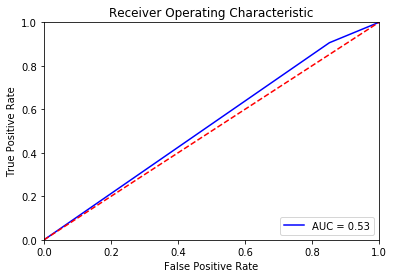

In [40]:
fpr, tpr, threshold = metrics.roc_curve(Y_Test, forest_preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Missing Values**

In [41]:
print("Check for Percent of missing values in dataset")
null_check=all_data.isnull().sum()
(null_check/len(all_data))*100

Check for Percent of missing values in dataset


id                                               0.000000
teacher_id                                       0.000000
teacher_prefix                                   0.002197
school_state                                     0.000000
project_submitted_datetime                       0.000000
project_grade_category                           0.000000
project_subject_categories                       0.000000
project_subject_subcategories                    0.000000
project_title                                    0.000000
project_essay_1                                  0.000000
project_essay_2                                  0.000000
project_essay_3                                 96.499341
project_essay_4                                 96.499341
project_resource_summary                         0.000000
teacher_number_of_previously_posted_projects     0.000000
project_is_approved                              0.000000
description                                      0.000000
price         

In [42]:
all_data.teacher_prefix = all_data.teacher_prefix.fillna('Unknown')

In [43]:
print("Check for Percent of missing values in dataset")
null_check=all_data.isnull().sum()
(null_check/len(all_data))*100

Check for Percent of missing values in dataset


id                                               0.000000
teacher_id                                       0.000000
teacher_prefix                                   0.000000
school_state                                     0.000000
project_submitted_datetime                       0.000000
project_grade_category                           0.000000
project_subject_categories                       0.000000
project_subject_subcategories                    0.000000
project_title                                    0.000000
project_essay_1                                  0.000000
project_essay_2                                  0.000000
project_essay_3                                 96.499341
project_essay_4                                 96.499341
project_resource_summary                         0.000000
teacher_number_of_previously_posted_projects     0.000000
project_is_approved                              0.000000
description                                      0.000000
price         

Joining essay columns

In [44]:
all_data[['project_essay_3','project_essay_4']] = all_data[['project_essay_3','project_essay_4']].fillna('')

In [45]:
all_data.dtypes

id                                               object
teacher_id                                       object
teacher_prefix                                   object
school_state                                     object
project_submitted_datetime                       object
project_grade_category                           object
project_subject_categories                       object
project_subject_subcategories                    object
project_title                                    object
project_essay_1                                  object
project_essay_2                                  object
project_essay_3                                  object
project_essay_4                                  object
project_resource_summary                         object
teacher_number_of_previously_posted_projects      int64
project_is_approved                               int64
description                                      object
price                                           

In [46]:
all_data['all_essay'] = all_data[['project_essay_1','project_essay_2','project_essay_3','project_essay_4']].apply(lambda x: ' '.join(x), axis=1)

In [47]:
all_data.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,price,quantity,all_essay
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,,,My students need 6 Ipod Nano's to create and d...,26,1,Apple - iPod nano� 16GB MP3 Player (8th Genera...,299.98,6,Most of my kindergarten students come from low...
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,,,My students need matching shirts to wear for d...,1,0,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,20.00,20,Our elementary school is a culturally rich sch...
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,,,My students need the 3doodler. We are an SEM s...,5,1,3doodler Start Full Edu Bundle,469.99,1,Hello;\r\nMy name is Mrs. Brotherton. I teach ...
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",,,My students need balls and other activity equi...,16,0,BALL PG 4'' POLY SET OF 6 COLORS BALL PLAYGROU...,684.47,5,My students are the greatest students but are ...
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,,,My students need a water filtration system for...,42,1,Crown Berkey Water Filter With 2 Black and 2 P...,355.50,2,My students are athletes and students who are ...


In [48]:
all_data["project_submitted_datetime"] = pd.to_datetime(all_data["project_submitted_datetime"],format='%Y-%m-%d %H:%M:%S')

**Date Features**

In [49]:
all_data.dtypes

id                                                      object
teacher_id                                              object
teacher_prefix                                          object
school_state                                            object
project_submitted_datetime                      datetime64[ns]
project_grade_category                                  object
project_subject_categories                              object
project_subject_subcategories                           object
project_title                                           object
project_essay_1                                         object
project_essay_2                                         object
project_essay_3                                         object
project_essay_4                                         object
project_resource_summary                                object
teacher_number_of_previously_posted_projects             int64
project_is_approved                                    

In [50]:
# extracting datetime features using datetime module 
all_data["Year"] = all_data["project_submitted_datetime"].dt.year
all_data["Month"] = all_data["project_submitted_datetime"].dt.month
all_data['Weekday'] = all_data['project_submitted_datetime'].dt.weekday
all_data["Hour"] = all_data["project_submitted_datetime"].dt.hour
all_data["Month_Day"] = all_data['project_submitted_datetime'].dt.day
all_data["Year_Day"] = all_data['project_submitted_datetime'].dt.dayofyear


In [51]:
import datetime
change_dt = datetime.datetime.fromtimestamp(time.mktime(time.strptime('2016-05-17 00:00:00', "%Y-%m-%d %H:%M:%S")))

all_data["new_essay_version"] = [1 if x>change_dt else 0 for x in all_data["project_submitted_datetime"] ]

**Text Features**

In [52]:
import re
def preprocess(string):
   
    string = re.sub(r'(\")', '', string)
    string = re.sub(r'(\r)', '', string)
    string = re.sub(r'(\n)', '', string)
    string = re.sub(r'(\r\n)','', string)
    string = re.sub(r'(\\)', '', string)
    string = re.sub(r'\t', '', string)
    string = re.sub(r'\:', '', string)
    string = re.sub(r'\"\"\"\"', '', string)
    string = re.sub(r'_', '', string)
    string = re.sub(r'\+', '', string)
    string = re.sub(r'\=', '', string)
    string = re.sub(r'\r\n', '', string)
    string = re.sub(r'\r\n\r\n', '', string)
    string = re.sub(r'rnrn', '', string)
    

    return string

all_data["all_essay"]=all_data["all_essay"].apply(preprocess)
all_data["project_title"]=all_data["project_title"].apply(preprocess)

all_data["all_essay"]=all_data["all_essay"].str.strip()
all_data["project_title"]=all_data["project_title"].str.strip()

all_data['all_essay'] = all_data['all_essay'].apply(lambda x: " ".join(x.split()))
all_data['project_title'] = all_data['project_title'].apply(lambda x: " ".join(x.split()))

In [53]:
all_data['char_count_essays'] = all_data['all_essay'].apply(len)

In [54]:
all_data['word_count'] = all_data['all_essay'].apply(lambda x: len(x.split()))

In [55]:
import string
all_data['punctuation_count'] = all_data['all_essay'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

In [56]:
all_data['title_word_count'] = all_data['project_title'].apply(lambda x: len(x.split()))

In [57]:
stop_words = list(set(stopwords.words('english')))
all_data['stopword_count_essays'] = all_data['all_essay'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

In [58]:
all_data['char_count_essays'].describe()

count    182080.000000
mean       1508.265685
std         393.545016
min         417.000000
25%        1202.000000
50%        1402.000000
75%        1722.000000
max        4885.000000
Name: char_count_essays, dtype: float64

In [59]:
from textblob import TextBlob
all_data['title_polarity'] = all_data['project_title'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [60]:
all_data['title_subjectivity'] = all_data['project_title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [61]:
'''
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}


def pos_check(x, flag):
    mytext = nltk.word_tokenize(x)
    tags = nltk.pos_tag(mytext)
    cnt = 0
    try:
        for tup in tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt
'''

"\npos_dic = {\n    'noun' : ['NN','NNS','NNP','NNPS'],\n    'pron' : ['PRP','PRP$','WP','WP$'],\n    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],\n    'adj' :  ['JJ','JJR','JJS'],\n    'adv' : ['RB','RBR','RBS','WRB']\n}\n\n\ndef pos_check(x, flag):\n    mytext = nltk.word_tokenize(x)\n    tags = nltk.pos_tag(mytext)\n    cnt = 0\n    try:\n        for tup in tags:\n            ppo = list(tup)[1]\n            if ppo in pos_dic[flag]:\n                cnt += 1\n    except:\n        pass\n    return cnt\n"

In [62]:
#all_data['noun_count_essay'] = all_data['all_essay'].apply(lambda x: pos_check(x, 'noun'))

In [63]:
#all_data['verb_count_essay'] = all_data['all_essay'].apply(lambda x: pos_check(x, 'verb'))
#all_data['adj_count_essay'] = all_data['all_essay'].apply(lambda x: pos_check(x, 'adj'))
#all_data['adv_count_essay'] = all_data['all_essay'].apply(lambda x: pos_check(x, 'adv'))
#all_data['pron_count_essay'] = all_data['all_essay'].apply(lambda x: pos_check(x, 'pron'))

In [64]:
# Creating the gender column
gender_mapping = {"Mrs.": "Female", "Ms.":"Female", "Mr.":"Male", "Teacher":"Unknown", "Dr.":"Unknown", np.nan:"Unknown"  }
all_data["gender"] = all_data.teacher_prefix.map(gender_mapping)

In [65]:
from sklearn import preprocessing
def encode_features(df_train):
    features = [
    'teacher_id', 
    'teacher_prefix', 
    'school_state', 
    'project_grade_category',
    'project_subject_categories', 
    'project_subject_subcategories',
    'gender']
    
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_train[feature].astype(str))
        df_train[feature] = le.transform(df_train[feature].astype(str))
        
    return df_train
    
train_data_final = encode_features(all_data)

Saving Progress

In [66]:
outfile = open('after_sentiment','wb')
pickle.dump(train_data_final,outfile)
outfile.close()

In [67]:
#infile = open('after_sentiment','rb')
#train_data_final = pickle.load(infile)
#infile.close()

In [68]:
len(train_data_final)

182080

**TF-IDF features**

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'),max_features=100)
Y_vec_pt = vectorizer.fit_transform(train_data_final['project_title'])

In [70]:
vectorizer2 = TfidfVectorizer(stop_words=stopwords.words('english'),max_features=1000)
Y_vec_ess = vectorizer2.fit_transform(train_data_final['all_essay'])

In [71]:
pt_columns = ['pt_'+x for x in vectorizer.get_feature_names() ]
pt_columns

['pt_21st',
 'pt_active',
 'pt_art',
 'pt_book',
 'pt_books',
 'pt_building',
 'pt_center',
 'pt_centers',
 'pt_century',
 'pt_chromebooks',
 'pt_class',
 'pt_classroom',
 'pt_create',
 'pt_creating',
 'pt_creative',
 'pt_day',
 'pt_education',
 'pt_engaging',
 'pt_first',
 'pt_flexible',
 'pt_fun',
 'pt_future',
 'pt_get',
 'pt_getting',
 'pt_go',
 'pt_good',
 'pt_grade',
 'pt_graders',
 'pt_great',
 'pt_hands',
 'pt_headphones',
 'pt_healthy',
 'pt_hear',
 'pt_help',
 'pt_interactive',
 'pt_ipad',
 'pt_ipads',
 'pt_keep',
 'pt_kids',
 'pt_kindergarten',
 'pt_learn',
 'pt_learners',
 'pt_learning',
 'pt_let',
 'pt_library',
 'pt_life',
 'pt_like',
 'pt_listening',
 'pt_literacy',
 'pt_little',
 'pt_love',
 'pt_make',
 'pt_making',
 'pt_materials',
 'pt_math',
 'pt_minds',
 'pt_move',
 'pt_moving',
 'pt_music',
 'pt_need',
 'pt_needed',
 'pt_needs',
 'pt_new',
 'pt_oh',
 'pt_one',
 'pt_part',
 'pt_place',
 'pt_play',
 'pt_please',
 'pt_project',
 'pt_read',
 'pt_readers',
 'pt_reading'

In [72]:
ess_columns = ['ess_'+x for x in vectorizer2.get_feature_names()]
ess_columns

['ess_10',
 'ess_100',
 'ess_12',
 'ess_1st',
 'ess_20',
 'ess_21st',
 'ess_25',
 'ess_2nd',
 'ess_30',
 'ess_3d',
 'ess_3rd',
 'ess_4th',
 'ess_50',
 'ess_5th',
 'ess_60',
 'ess_6th',
 'ess_7th',
 'ess_8th',
 'ess_90',
 'ess_abilities',
 'ess_ability',
 'ess_able',
 'ess_academic',
 'ess_academically',
 'ess_academics',
 'ess_access',
 'ess_accessible',
 'ess_accomplish',
 'ess_achieve',
 'ess_achievement',
 'ess_across',
 'ess_active',
 'ess_actively',
 'ess_activities',
 'ess_activity',
 'ess_actually',
 'ess_add',
 'ess_adding',
 'ess_addition',
 'ess_additional',
 'ess_adhd',
 'ess_adults',
 'ess_afford',
 'ess_african',
 'ess_age',
 'ess_allow',
 'ess_allowing',
 'ess_allows',
 'ess_almost',
 'ess_along',
 'ess_already',
 'ess_also',
 'ess_alternative',
 'ess_although',
 'ess_always',
 'ess_amazing',
 'ess_american',
 'ess_among',
 'ess_amount',
 'ess_another',
 'ess_answer',
 'ess_anything',
 'ess_applications',
 'ess_apply',
 'ess_appreciate',
 'ess_approach',
 'ess_appropriate

In [73]:
pt_features = pd.DataFrame(data=Y_vec_pt.toarray(), columns=pt_columns)

In [74]:
ess_features = pd.DataFrame(data=Y_vec_ess.toarray(), columns=ess_columns)

In [75]:
pt_features.sample(5)

,pt_21st,pt_active,pt_art,pt_book,pt_books,pt_building,pt_center,pt_centers,pt_century,pt_chromebooks,...,pt_tools,pt_us,pt_using,pt_way,pt_wiggle,pt_wobble,pt_work,pt_world,pt_writing,pt_year
118436,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181530,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125173,0.0,0.0,0.0,0.0,0.687802,0.0,0.0,0.0,0.0,0.0,...,0.0,0.725898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4411,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109529,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
ess_features.sample(5)

,ess_10,ess_100,ess_12,ess_1st,ess_20,ess_21st,ess_25,ess_2nd,ess_30,ess_3d,...,ess_would,ess_write,ess_writers,ess_writing,ess_written,ess_year,ess_years,ess_yet,ess_yoga,ess_young
107417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
171470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
117856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.119525,0.0,0.0
159793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
57140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046209,0.0,0.0,0.0,0.0,0.045002,0.0,0.086280,0.0,0.0


In [77]:
print('value counts pt_features: {} '.format(len(pt_features)) )

value counts pt_features: 182080 


In [78]:
print('value counts ess_features: {} '.format(len(ess_features)) )

value counts ess_features: 182080 


In [79]:
train_data_final = pd.concat([train_data_final, pt_features, ess_features],join='inner', axis=1)

In [80]:
len(train_data_final)

182080

In [81]:
cols_to_remove = ['teacher_prefix','id','project_title','project_essay_1','project_essay_2','project_essay_3',
                  'project_essay_4','all_essay','project_resource_summary','project_submitted_datetime','description']

train_data_final = train_data_final.drop(cols_to_remove, axis = 1)

In [82]:
train_data_final.dtypes.value_counts()

float64    1103
int64        21
dtype: int64

Saving Progress

In [83]:
outfile_2 = open('ready_4_modeling','wb')
pickle.dump(train_data_final,outfile_2)
outfile_2.close()

In [84]:
#infile_2 = open('ready_4_modeling','rb')
#train_data_final = pickle.load(infile_2)
#infile_2.close()

**Modeling**

In [85]:
y2 = train_data_final.project_is_approved.copy()
X2 = train_data_final.copy()

X2=X2.drop('project_is_approved',axis=1)

In [86]:
X2.head()

,teacher_id,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,price,quantity,Year,Month,...,ess_would,ess_write,ess_writers,ess_writing,ess_written,ess_year,ess_years,ess_yet,ess_yoga,ess_young
0,29315,33,3,24,321,26,299.98,6,2016,11,...,0.066496,0.0,0.0,0.0,0.0,0.097140,0.000000,0.0,0.0,0.0
1,91061,10,0,42,392,1,20.00,20,2017,4,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,69247,44,0,36,17,5,469.99,1,2017,1,...,0.104257,0.0,0.0,0.0,0.0,0.000000,0.075585,0.0,0.0,0.0
3,33451,27,0,8,293,16,684.47,5,2016,8,...,0.000000,0.0,0.0,0.0,0.0,0.024132,0.000000,0.0,0.0,0.0
4,67811,4,1,8,293,42,355.50,2,2016,8,...,0.097234,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [87]:
y2.value_counts()

1    154346
0     27734
Name: project_is_approved, dtype: int64

**LightGBM**

In [88]:
#. define gridsearch parameters
#   a) model complexity
        #i)  max_depth
        #ii) min_child_weight
#   b) randomness
        #i)  subsample
        #ii) colsample_bytree
#   c) stepsize
        #i)  eta = n_estimators
        #ii) learning_rate
#   d) weighting positive data
        #i) scale_pos_weight

X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(X2, y2, test_size=0.25, random_state=2018)

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 7,
        'num_leaves': 32,
        'learning_rate': 0.05,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 100,
        'lambda_l2': 1,
    }  

import lightgbm as lgb
evals_result = {}  # to record eval results for plotting
model_lgb = lgb.train(
        params,
        lgb.Dataset(X_train_l, y_train_l),
        num_boost_round=10000,
        valid_sets=[lgb.Dataset(X_valid_l, y_valid_l)],
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=50)
valid_preds_lgb = model_lgb.predict(X_valid_l, num_iteration=model_lgb.best_iteration)
auc = roc_auc_score(y_valid_l, valid_preds_lgb)
print('AUC:',auc)
#0.7584

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.726015
[100]	valid_0's auc: 0.739629
[150]	valid_0's auc: 0.746609
[200]	valid_0's auc: 0.750764
[250]	valid_0's auc: 0.753699
[300]	valid_0's auc: 0.754878
[350]	valid_0's auc: 0.756063
[400]	valid_0's auc: 0.756916
[450]	valid_0's auc: 0.757506
[500]	valid_0's auc: 0.757862
[550]	valid_0's auc: 0.758215
[600]	valid_0's auc: 0.758285
[650]	valid_0's auc: 0.758126
Early stopping, best iteration is:
[595]	valid_0's auc: 0.758428
AUC: 0.7584275483628934


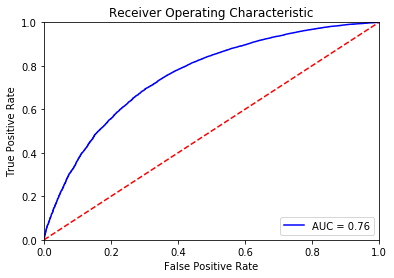

In [89]:
fpr, tpr, threshold = metrics.roc_curve(y_valid_l, valid_preds_lgb)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()